This particular challenge is perfect for data scientists looking to get started with Natural Language Processing. You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

# Data overview

* `id` - a unique identifier for each tweet
* `text` - the text of the tweet
* `location` - the location the tweet was sent from (may be blank)
* `keyword` - a particular keyword from the tweet (may be blank)
* `target` - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [1]:
# Import all the tools
import warnings
from tqdm import tqdm_notebook
import seaborn as sns
from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import nltk
from sklearn.experimental import enable_iterative_imputer
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
# from sklearn.impute import IterativeImputer
warnings.filterwarnings("ignore")

train = pd.read_csv(
    "/home/mikhail/data/Natural Language Processing with Disaster Tweets/train.csv")
test = pd.read_csv(
    "/home/mikhail/data/Natural Language Processing with Disaster Tweets/test.csv")
sub = pd.read_csv(
    '/home/mikhail/data/Natural Language Processing with Disaster Tweets/sample_submission.csv')
#train.drop('keyword', axis=1, inplace=True)
#train.drop('location', axis=1, inplace=True)
# y = train['target']
# train.drop('target', axis=1, inplace=True)

# plots inside the notebook
%matplotlib inline
print('Train Shape: {}\nMissing Data: {}\nDuplicates: {}\n'.format(
    train.shape, train.isna().sum().sum(), train.duplicated().sum()))
print('Test Shape: {}\nMissing Data: {}\nDuplicates: {}\n'.format(
    test.shape, test.isna().sum().sum(), test.duplicated().sum()))
train_d = train.drop_duplicates()

if train.shape == train_d.shape:
    print('No duplicates')
else:
    print('Dropping Duplicates\nNew Train Shape: {}'.format(train_d.shape))

Train Shape: (7613, 5)
Missing Data: 2594
Duplicates: 0

Test Shape: (3263, 4)
Missing Data: 1131
Duplicates: 0

No duplicates


In [2]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Exploratory Data Analysis (EDA)

In [4]:
train.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [5]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
train['location'].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [7]:
train['location'].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [8]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

or

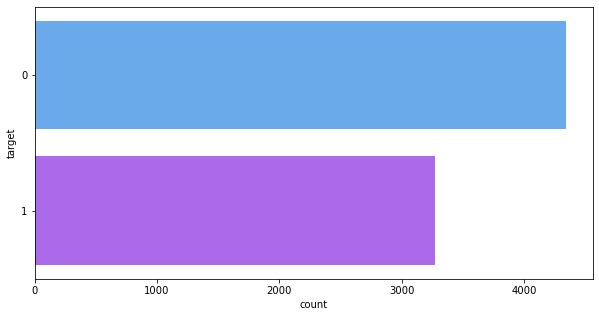

In [9]:
plt.figure(figsize=(10,5))
sns.countplot(y=train['target'], palette='cool', orient='h')
plt.show()

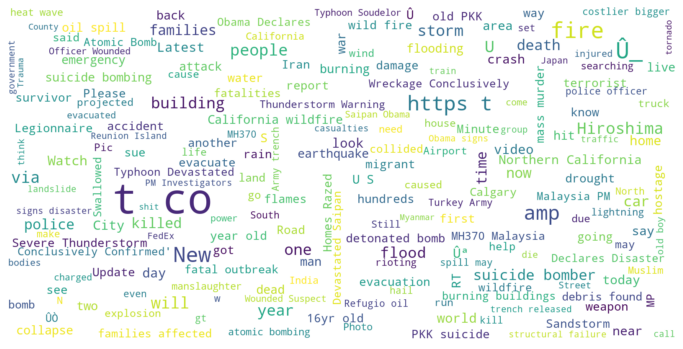

In [10]:
#Disaster Tweets wordcloud 
disaster_tweets = train[train.target == 1]
disaster_string = []
for t in disaster_tweets.text:
    disaster_string.append(t)
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Feature Engineering (FE)

## Feature generation

In [11]:
import string
import nltk
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')

# lenth
train['body_len'] = train['text'].apply(lambda x: len(x) - x.count(" "))
test['body_len'] = test['text'].apply(lambda x: len(x) - x.count(" "))

# % pucntuation
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100
train['punct%'] = train['text'].apply(lambda x: count_punct(x))
test['punct%'] = test['text'].apply(lambda x: count_punct(x))

# word_count
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train['stop_word_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword]))
test['stop_word_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword]))

# url_count
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test['url_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
test['char_count'] = test['text'].apply(lambda x: len(str(x)))

train.head(2)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mikhail/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,keyword,location,text,target,body_len,punct%,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,1.8,13,13,6,0,4.384615,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,3.1,7,7,0,0,4.571429,38


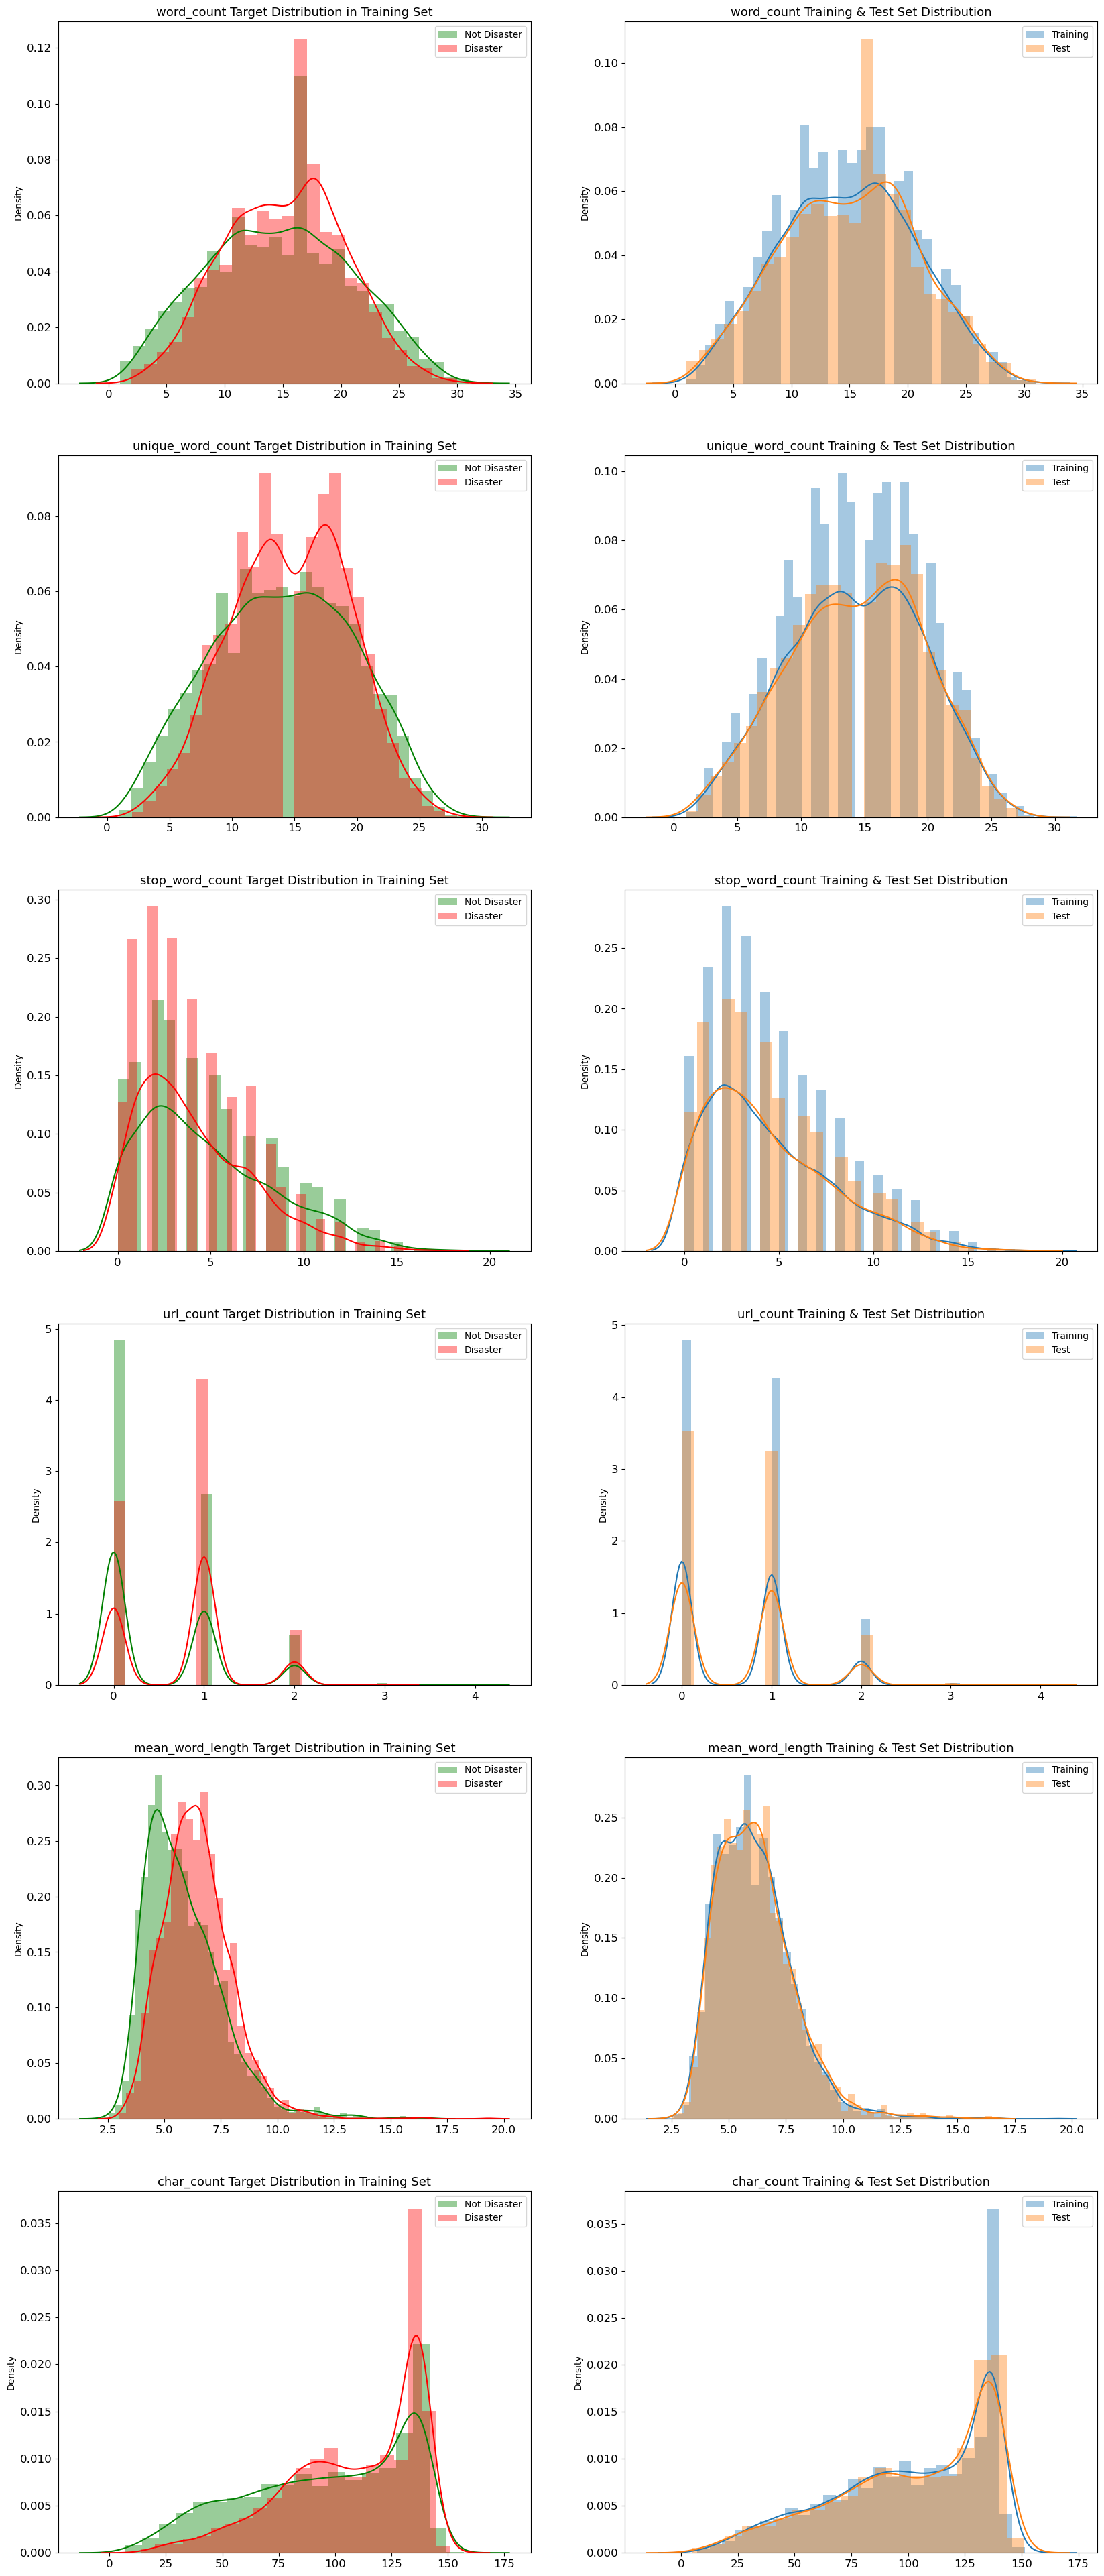

In [12]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count']
DISASTER_TWEETS = train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(train[feature], label='Training', ax=axes[i][1])
    sns.distplot(test[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

## Punctuation removing

In [13]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
def remove_punct(text):
    text_punct = "".join([char for char in text if char not in string.punctuation])
    return text_punct

train['text_punct'] = train['text'].apply(lambda x:remove_punct(x))
test['text_punct'] = test['text'].apply(lambda x:remove_punct(x))
train.head(2)

,id,keyword,location,text,target,body_len,punct%,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,text_punct
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,1.8,13,13,6,0,4.384615,69,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,3.1,7,7,0,0,4.571429,38,Forest fire near La Ronge Sask Canada


In [15]:
train['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

## Tokenization

In [16]:
import re
def tokenize(text):
    tokens = re.split('\W+', text) # W+ mean that either a word character (A-Za-9) or a dash(-) can go there
    return tokens
train['text_tokens'] = train['text_punct'].apply(lambda x:tokenize(x.lower()))
test['text_tokens'] = test['text_punct'].apply(lambda x:tokenize(x.lower()))
train.head(2)

,id,keyword,location,text,target,body_len,punct%,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,text_punct,text_tokens
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,1.8,13,13,6,0,4.384615,69,Our Deeds are the Reason of this earthquake Ma...,"[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,3.1,7,7,0,0,4.571429,38,Forest fire near La Ronge Sask Canada,"[forest, fire, near, la, ronge, sask, canada]"


## Stop-words removing

In [17]:
import nltk
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
#stopword

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mikhail/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def remove_stodwords(tokenized_list):
    text = [word for word in tokenized_list if word not in stopword]
    return text
train['text_stopwords'] = train['text_tokens'].apply(lambda x:remove_stodwords(x))
test['text_stopwords'] = test['text_tokens'].apply(lambda x:remove_stodwords(x))
train.head(2)

,id,keyword,location,text,target,body_len,punct%,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,text_punct,text_tokens,text_stopwords
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,1.8,13,13,6,0,4.384615,69,Our Deeds are the Reason of this earthquake Ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,3.1,7,7,0,0,4.571429,38,Forest fire near La Ronge Sask Canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"


## Stemming or lemmatizing

Lemmatization is more complex but precise. Choose it.

In [19]:
# ps = nltk.PorterStemmer()

# def stemming(text_stopwords):
#     text = [ps.stem(word) for word in text_stopwords]
#     return text

# train['text_stemming'] = train['text_stopwords'].apply(lambda x:stemming(x))
# train.head()

In [20]:
wn = nltk.WordNetLemmatizer()
nltk.download('wordnet')
def lemmatizing(text_stopwords):
    text = [wn.lemmatize(word) for word in text_stopwords]
    return text

train['text_lemmatizing'] = train['text_stopwords'].apply(lambda x:lemmatizing(x))
test['text_lemmatizing'] = test['text_stopwords'].apply(lambda x:lemmatizing(x))
train.head(2)

[nltk_data] Downloading package wordnet to /home/mikhail/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,keyword,location,text,target,body_len,punct%,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,text_punct,text_tokens,text_stopwords,text_lemmatizing
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,1.8,13,13,6,0,4.384615,69,Our Deeds are the Reason of this earthquake Ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,3.1,7,7,0,0,4.571429,38,Forest fire near La Ronge Sask Canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"


In [21]:
y = train['target']
train.drop('target', axis=1, inplace=True)

train.drop('text_punct', axis=1, inplace=True)
train.drop('text_tokens', axis=1, inplace=True)
train.drop('text_stopwords', axis=1, inplace=True)
train.drop('keyword', axis=1, inplace=True)
train.drop('location', axis=1, inplace=True)
train.drop('id', axis=1, inplace=True)

test.drop('text_punct', axis=1, inplace=True)
test.drop('text_tokens', axis=1, inplace=True)
test.drop('text_stopwords', axis=1, inplace=True)
test.drop('keyword', axis=1, inplace=True)
test.drop('location', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

train.head(3)

,text,body_len,punct%,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,text_lemmatizing
0,Our Deeds are the Reason of this #earthquake M...,57,1.8,13,13,6,0,4.384615,69,"[deed, reason, earthquake, may, allah, forgive..."
1,Forest fire near La Ronge Sask. Canada,32,3.1,7,7,0,0,4.571429,38,"[forest, fire, near, la, ronge, sask, canada]"
2,All residents asked to 'shelter in place' are ...,112,2.7,22,20,11,0,5.090909,133,"[resident, asked, shelter, place, notified, of..."


In [22]:
test.head(3)

,text,body_len,punct%,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,text_lemmatizing
0,Just happened a terrible car crash,29,0.0,6,6,2,0,4.833333,34,"[happened, terrible, car, crash]"
1,"Heard about #earthquake is different cities, s...",56,5.4,9,9,2,0,6.222222,64,"[heard, earthquake, different, city, stay, saf..."
2,"there is a forest fire at spot pond, geese are...",78,2.6,19,19,9,0,4.105263,96,"[forest, fire, spot, pond, goose, fleeing, acr..."


## Vectorizing

Bag of Words (BoW) or CountVectorizer describes the presence of words in text data. This gives a result of 1 if present in the sentence and 0 if not present.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
# wn = nltk.WordNetLemmatizer()
# nltk.download('wordnet')
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    # Now just remove any stopwords
    text = [word for word in nopunc.split() if word.lower() not in stopword]
    #text = [wn.lemmatize(word) for word in text]
    return text

# Check it
train['text'].head(5).apply(text_process)

0    [Deeds, Reason, earthquake, May, ALLAH, Forgiv...
1        [Forest, fire, near, La, Ronge, Sask, Canada]
2    [residents, asked, shelter, place, notified, o...
3    [13000, people, receive, wildfires, evacuation...
4    [got, sent, photo, Ruby, Alaska, smoke, wildfi...
Name: text, dtype: object

In [24]:
# Train
bow_transformer = CountVectorizer(analyzer=text_process).fit(train['text'])
transformed_x = bow_transformer.transform(train['text'])
print('Shape of Train Matrix: ', transformed_x.shape)
print('Train shape:', train.shape)
X = pd.DataFrame(transformed_x.toarray())
# numeric features
train.drop('text', axis=1, inplace=True)
train.drop('text_lemmatizing', axis=1, inplace=True)
# Merge
X = pd.concat([X, train], axis=1)
X.head(3)

Shape of Train Matrix:  (7613, 26473)
Train shape: (7613, 10)


,0,1,2,3,4,5,6,7,8,9,...,26471,26472,body_len,punct%,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count
0,0,0,0,0,0,0,0,0,0,0,...,0,0,57,1.8,13,13,6,0,4.384615,69
1,0,0,0,0,0,0,0,0,0,0,...,0,0,32,3.1,7,7,0,0,4.571429,38
2,0,0,0,0,0,0,0,0,0,0,...,0,0,112,2.7,22,20,11,0,5.090909,133


In [25]:
# Test
#bow_transformer = CountVectorizer(analyzer=text_process).fit(test['text'])
transformed_x = bow_transformer.transform(test['text'])
print('Shape of Test Matrix: ', transformed_x.shape)
print('Test shape:', test.shape)
X_test = pd.DataFrame(transformed_x.toarray())

# numeric features
test.drop('text', axis=1, inplace=True)
test.drop('text_lemmatizing', axis=1, inplace=True)
# Merge
test = pd.concat([X_test, test], axis=1)
test.head(3)

Shape of Test Matrix:  (3263, 26473)
Test shape: (3263, 10)


,0,1,2,3,4,5,6,7,8,9,...,26471,26472,body_len,punct%,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count
0,0,0,0,0,0,0,0,0,0,0,...,0,0,29,0.0,6,6,2,0,4.833333,34
1,0,0,0,0,0,0,0,0,0,0,...,0,0,56,5.4,9,9,2,0,6.222222,64
2,0,0,0,0,0,0,0,0,0,0,...,0,0,78,2.6,19,19,9,0,4.105263,96


## N-grams

It count words after each words (context)

In [26]:
# from sklearn.feature_extraction.text import CountVectorizer

# ngram_vec = CountVectorizer(ngram_range=(2,2))
# X_counts = ngram_vec.fit_transform(train['text'])
# print(X_counts.shape)
#print(ngram_vec.get_feature_names())

## TF-IDF (frequency)

In [27]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf_vect = TfidfVectorizer(lowercase=False)
# # X_tfidt = tfidf_vect.fit_transform(train['text_lemmatizing'])


# print(X_tfidt.shape)
#print(tfidf_vect.get_feature_names())

In [28]:
# train['text_lemmatizing']

# Modeling

In [29]:
N_SPLITS = 3 # 10 is better but memory allocated
N_ESTIMATORS = 250 # 300, 500 1000 is better but It will take a little longer.and memory problems.
RANDOM_STATE = 42 # tried 1,42 

params = {
    'n_estimators' : N_ESTIMATORS,
    'n_jobs' : -1,
     'random_state' : RANDOM_STATE
}

#train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)

scores_2 = []
scores_3 = []

y_probs_2 = []
y_probs_3 = []

folds = StratifiedKFold(n_splits = N_SPLITS, shuffle=True)

for fold, (train_id, test_id) in enumerate(folds.split(X, y)):  
    
    print("fold : ", fold + 1, end = ' ')
  
    X_train = X.iloc[train_id]
    y_train = y.iloc[train_id]
    X_valid = X.iloc[test_id]
    y_valid = y.iloc[test_id]
    
    # model_2
    
    model_2 =  ExtraTreesClassifier(**params)
    #model_2 =  RandomForestClassifier(**params)
    model_2.fit(X_train, y_train)
    # validation
    valid_pred_2 = model_2.predict(X_valid)
    valid_score_2 = accuracy_score(y_valid, valid_pred_2)
    print( "model_2 :: Accuracy_score: ", valid_score_2, end = ' ')
    scores_2.append(valid_score_2)
    
    # test
    y_pred_2 = model_2.predict(test)
    y_probs_2.append(model_2.predict_proba(test))
   
    
    # model_3
  
    model_3 = BaggingClassifier(model_2,  random_state = RANDOM_STATE)
    model_3.fit(X_train, y_train)
    valid_pred_3 = model_3.predict(X_valid)
    valid_score_3 = accuracy_score(y_valid, valid_pred_3)
    print( "model_3 :: Accuracy_score: ", valid_score_3)
    scores_3.append(valid_score_3)
    
    # test
    y_pred_3 = model_3.predict(test)
    y_probs_3.append(model_3.predict_proba(test))

fold :  1 model_2 :: Accuracy_score:  0.7675334909377463 model_3 :: Accuracy_score:  0.7584712371946415
fold :  2 model_2 :: Accuracy_score:  0.7734436564223798 

KeyboardInterrupt: 

In [35]:
model =  RandomForestClassifier(random_state=42, verbose=1, n_jobs=-1)
model.fit(X,y)
y_preds = model.predict(test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


# Submission

In [ ]:
# ETC+ bagging results
y_prob_3 = sum(y_probs_3) / len(y_probs_3)
y_pred_tuned_3 = label.inverse_transform(np.argmax(y_prob_3, axis = 1))
pd.Series(y_pred_tuned_3, index = test.index).value_counts().sort_index()  / len(test) * 100

In [ ]:
y_prob_3 += np.array([0, 0, 0.01, 0.03, 0, 0, 0, 0.0, 0, 0]) # change may vary 
y_pred_tuned_3 = label.inverse_transform(np.argmax(y_prob_3, axis = 1))
pd.Series(y_pred_tuned_3, index=test.index).value_counts().sort_index() / len(test) * 100

In [38]:
sub.head(2)

,id,target
0,0,0
1,2,0


In [39]:
def save_submission(y_pred):  
    #classes = label.inverse_transform(y_pred)
    sub["target"] = y_pred
    #assert len(classes) == sub.shape[0]
    assert 2 == sub.shape[1]   
    sub.to_csv("/home/mikhail/Downloads/sample_submission.csv'", index=False)
    return sub
save_submission(y_preds).head(3)

,id,target
0,0,0
1,2,0
2,3,0
